# Imports

In [1]:
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
import torch

# MLP Implementation

In [2]:
# Read in all words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))

stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

vocab_size = len(itos)

print (itos)
print (vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
# Build the dataset
block_size = 3 # Context length stores how man characters are taken to predict the next one

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr    = build_dataset(words[:n1])     # 80%
Xdev, Ydev  = build_dataset(words[n1:n2])   # 10%
Xte, Yte    = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
# MLP Revisited
n_embd      = 10  # The dimensionality of the character embedding vectors
n_hidden    = 200 # The number of neurons in the hidden layer of the MLP

g   = torch.Generator().manual_seed(2147483647)
C   = torch.randn((vocab_size, n_embd),               generator = g)

W1  = torch.randn((n_embd * block_size, n_hidden),   generator = g) * (5/3) / ((n_embd * block_size)**0.5) # * 0.2
# b1  = torch.randn(n_hidden,                          generator = g) * 0.01
W2  = torch.randn((n_hidden,vocab_size),             generator = g) * 0.01
b2  = torch.randn(vocab_size,                        generator = g) * 0

bngain          = torch.ones ((1, n_hidden))
bnbias          = torch.zeros((1, n_hidden))
bnmean_running  = torch.zeros((1, n_hidden))
bnstd_running   = torch.ones ((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))    # Number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [7]:
# Training a deeper NN
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias   = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # Parameters (Trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta  = torch.zeros(dim)

        # Buffers (Trained with a running 'momentum update')
        self.running_mean   = torch.zeros(dim)
        self.running_var   = torch.ones(dim)

    def __call__(self, x):
        
        # Calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True)               # Batch mean
            xvar  = x.var(0, keepdim=True) # Batch variance
        else:
            xmean = self.running_mean
            xvar  = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)   # Normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # Update the buffers using exponential moving average
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var  = (1 - self.momentum) * self.running_var  + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    
n_embd  = 10                                     # The dimensionality of the character embedding vectors
n_hidden= 100                                  # The number of neurons in the hidden layer of the MLP
g       = torch.Generator().manual_seed(2147483647)   # For Reproducability

C = torch.randn((vocab_size, n_embd),   generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size),
]

with torch.no_grad():

    # Last layer: make less confident
    layers[-1].gamma *= 0.1
    # All other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))    # Number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [ ]:
# Optimizations
max_steps   = 200000
batch_size  = 32
lossi   = []
ud      = [] # Ratio of updates (learning rate * gradient) / (standard deviation of data (log10)) for all parameters

for i in range(max_steps):

    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix]           # Batch X, Y

    # Forward Pass
    emb = C[Xb]                         # Embed the characters into vectors
    x = emb.view(emb.shape[0], -1)      # Concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)       # Loss function

    # Backward Pass
    for layer in layers:
        layer.out.retain_grad() # Would take out retain_grad after debug
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01    # Step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    if i % 10000 == 0:                  # Print every once in a while
        print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # if i > 1000: # Comment in and out to run full loop or just once
    #     break

print(f'{i:7d} /{max_steps:7d}: {loss.item():.4f}')


      0 / 200000: 3.2870
  10000 / 200000: 2.3578
  20000 / 200000: 2.1043
  30000 / 200000: 1.9646
  40000 / 200000: 2.2144
  50000 / 200000: 2.2266
  60000 / 200000: 1.7339
  70000 / 200000: 2.1749
  80000 / 200000: 2.1895
  90000 / 200000: 1.8281
 100000 / 200000: 2.3634
 110000 / 200000: 2.2015
 120000 / 200000: 2.1032
 130000 / 200000: 1.8564
 140000 / 200000: 1.8051
 150000 / 200000: 1.9258
 160000 / 200000: 1.8763
 170000 / 200000: 1.8335
 180000 / 200000: 2.2314
 190000 / 200000: 2.0513
 199999 / 200000: 2.0513


# Visualizations

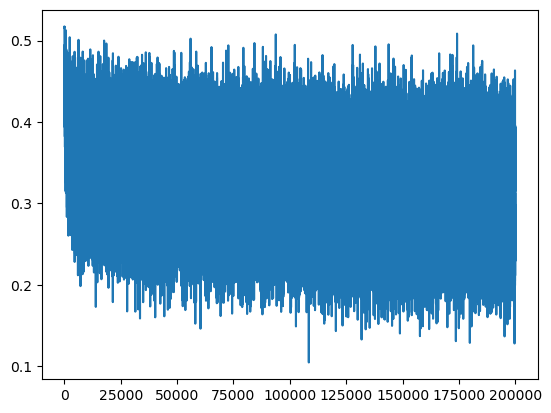

In [15]:
plt.plot(lossi)

layer 2 (      Tanh): mean -0.01, std 0.69, saturated: 14.03%
layer 5 (      Tanh): mean -0.02, std 0.72, saturated: 16.91%
layer 8 (      Tanh): mean -0.00, std 0.75, saturated: 15.75%
layer 11 (      Tanh): mean +0.02, std 0.77, saturated: 16.78%
layer 14 (      Tanh): mean -0.02, std 0.79, saturated: 18.72%


Text(0.5, 1.0, 'Activation Distribution')

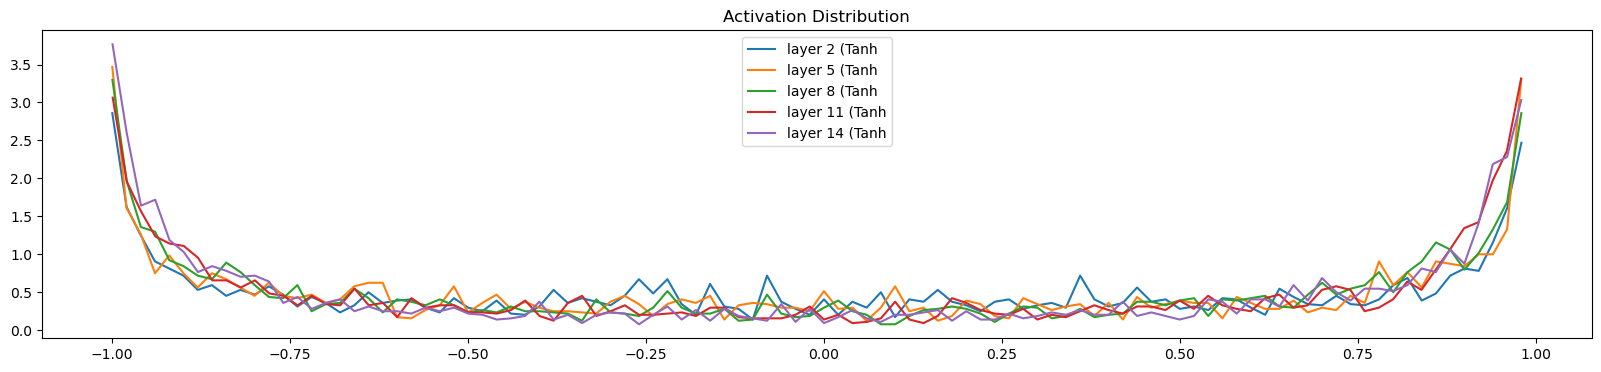

In [9]:
# Visualize histograms
plt.figure(figsize=(20, 4))             # Width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Activation Distribution')

layer 2 (      Tanh): mean -0.000000, std 3.413328e-03
layer 5 (      Tanh): mean +0.000000, std 3.279261e-03
layer 8 (      Tanh): mean -0.000000, std 3.260843e-03
layer 11 (      Tanh): mean -0.000000, std 3.532994e-03
layer 14 (      Tanh): mean -0.000000, std 3.843003e-03


Text(0.5, 1.0, 'Gradient Distribution')

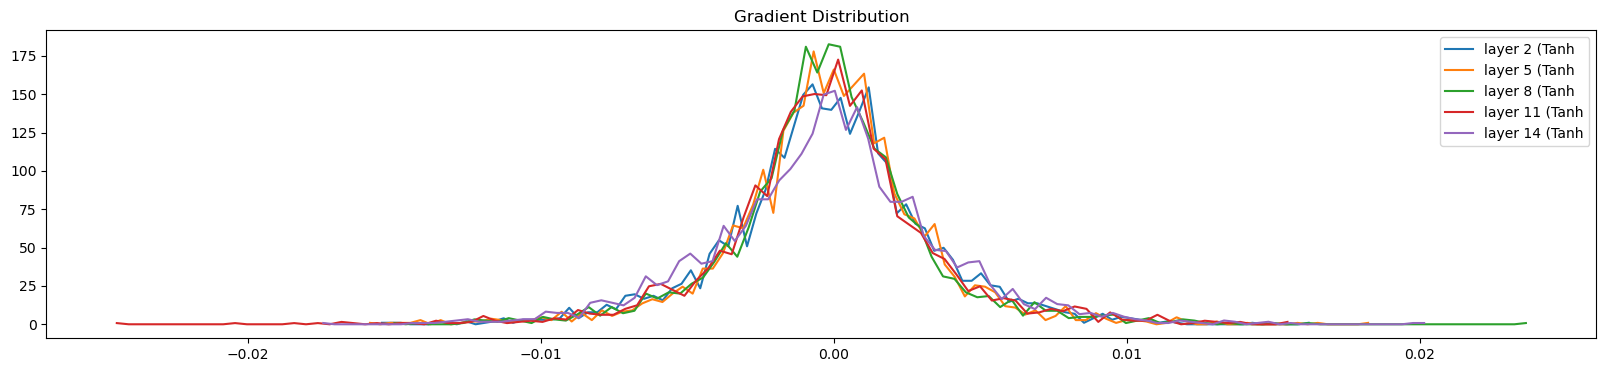

In [10]:
# Visualize histograms
plt.figure(figsize=(20, 4))             # Width and height of the plot
legends = []

for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy,hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('Gradient Distribution')

weight   (27, 10) | mean +0.000000 | std 1.496318e-02 | grad:data ratio 1.370163e-02
weight  (30, 100) | mean +0.000085 | std 7.867816e-03 | grad:data ratio 1.919648e-02
weight (100, 100) | mean +0.000060 | std 5.040184e-03 | grad:data ratio 2.041886e-02
weight (100, 100) | mean -0.000086 | std 5.160316e-03 | grad:data ratio 2.125704e-02
weight (100, 100) | mean +0.000044 | std 5.189185e-03 | grad:data ratio 2.190954e-02
weight (100, 100) | mean -0.000013 | std 5.229847e-03 | grad:data ratio 2.274837e-02
weight  (100, 27) | mean +0.000052 | std 9.163456e-03 | grad:data ratio 2.774516e-02


Text(0.5, 1.0, 'Weights Gradient Distribution')

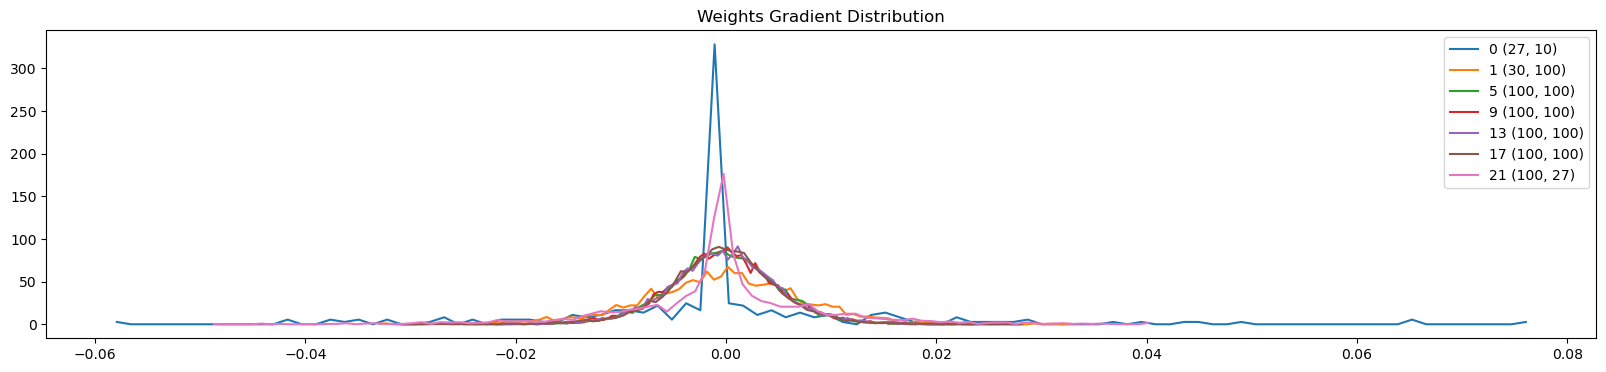

In [11]:
# Visualize histograms
plt.figure(figsize=(20, 4))             # Width and height of the plot
legends = []

for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends);
plt.title('Weights Gradient Distribution')

Text(0.5, 1.0, 'Log Update-to-Weight Ratio During Training')

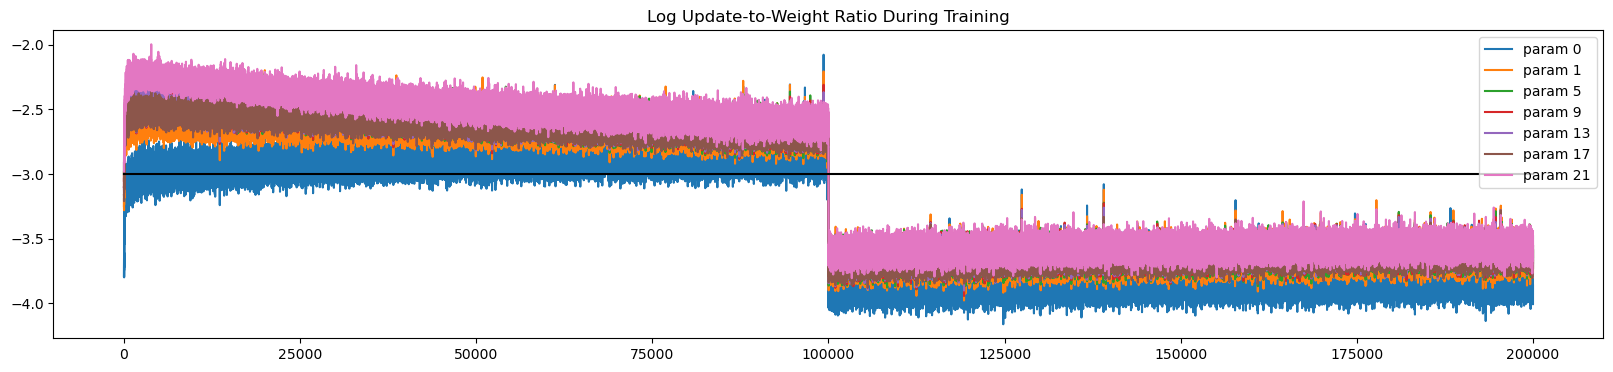

In [12]:
plt.figure(figsize=(20,4))
legends = []

for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range (len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)
plt.title('Log Update-to-Weight Ratio During Training')

In [13]:
@torch.no_grad()    # Disables gradient tracking
def split_loss(split):
    x, y = {
        'train':    (Xtr, Ytr),
        'val':      (Xdev, Ydev),
        'test':     (Xte, Yte),
    } [split]

    emb = C[x]                          # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # Concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

# Put laters into eval mode
for layer in layers:
    layer.training = False
split_loss('train')
split_loss('val')


train 2.0123209953308105
val 2.0841028690338135


# Sampling from Model

In [14]:
# Sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out     = []
    context = [0] * block_size    # Initialize with all ...'%%SVG

    while True:
        # Forward pass the neural net
        emb     = C[torch.tensor([context])]    # 1, block_size, n_embd
        x       = emb.view(emb.shape[0], -1)    # Concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits  = x
        probs   = F.softmax(logits, dim=1)

        # Sample from the distribution
        ix      = torch.multinomial(probs, num_samples=1, generator=g).item()

        # Shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))   # Decode and print the generated word

carlah.
amelle.
khyriri.
reity.
skanya.
eja.
hube.
deliah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joce.
quintis.
lilah.
jadiquinte.
madiaryn.
kai.
eupitraylen.
